---
# VisionSpace Challenge
---
### Description
This notebook contains all the solutions and explanations for all three challenges.
### Requirements
The subsequent cell installs all packages that were utilized to solve the tasks.

In [ ]:
%pip install -r requirements.txt

Now I import everything I need from these packages.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.functions import *

**Assumption 1:** Given that the challenge is designed to take approximately four hours, it is essential to prioritize the most promising approaches and methods.

# Challenge I
---
## Desciption
The Janus satellite provides information that supports ground exploration missions on Mars. A sample
of the dataset in .csv format and a short description of its columns can be found in this repository:
https://github.com/visionspacetec/ai-interview-challanges.
Your goal is to apply Machine Learning techniques to predict Janus’ power consumption.
## Solution
**Assumption 2:** Since the exact prediction target is not specified, I set it to a next hour prediction, which also fits well with real-time monitoring needs and can be helpful in detecting anomalies. Another possibility would be to predict the next 24-hour profile, which would be useful for battery planning or solar panel orientation. I decided against this goal because the dataset is only about 20 days long and such a prediction would be very challenging because there may be long-term trends or periodic variations that are not captured by the data.

I start my solution by loading the raw data from the csv file.

In [2]:
# Define relative path to the dataset
current_dir_path = os.getcwd()
data_file_path = os.path.join(current_dir_path, 'SatelliteDataSet.csv')

# Load data to dataframe from csv file
df = pd.read_csv(data_file_path)

# All avialable features
all_features = ["power", "sa", "sx", "sy", "sz", "sunmars_km", 
                "earthmars_km", "sunmarsearthangle_deg", 
                "solarconstantmars", "eclipseduration_min", 
                "occultationduration_min", "flagcomms", 
                "ACROSS_TRACK", "D1PVMC", "D4PNPO", "EARTH", "INERTIAL",
                "MAINTENANCE", "NADIR", "RADIO_SCIENCE", "SLEW", "WARMUP"]

# The prediction target
label_feature = "power"

In order to facilitate a more profound comprehension of the data, the initial step involves the graphical representation of the power consumption over the complete time span of 500 hours.

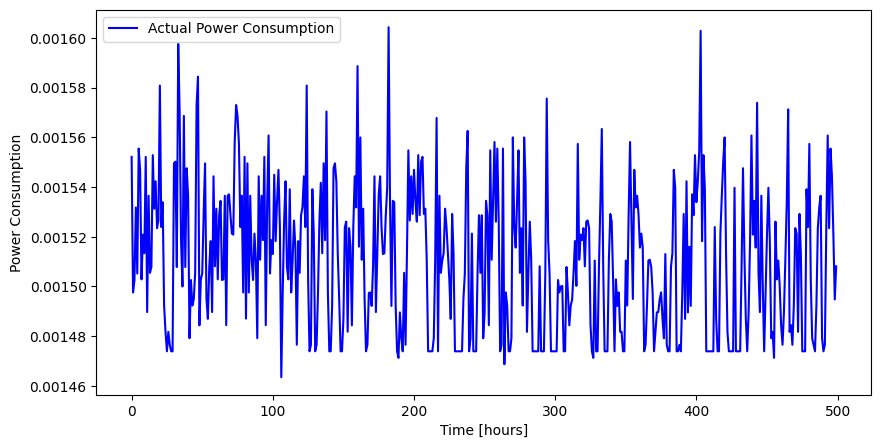

In [3]:
plot_power_time(y_test=df['power'].values)

**Note:** Due to the significant variations in satellite power consumption, it could also be useful to predict a rolling average in order to achieve a smoother pattern.

## Data Engineering

In the next step, I want to identify the features that have the most influence on the power consumption of the satellite. I start by calculating the correlation between "power" and all other features.


In [4]:
# Compute correlation of power consumption with each feature
calc_corr_of_feature(df, all_features, label_feature)

power corr: 0.38304193896251837
sa corr: 0.010232278603367171
sx corr: -0.020659383435740496
sy corr: 0.012383537069354298
sz corr: 0.014179640433799162
sunmars_km corr: 0.1962294165455303
earthmars_km corr: -0.20260707070038386
sunmarsearthangle_deg corr: 0.1976658647014179
solarconstantmars corr: -0.19570191037744972
eclipseduration_min corr: 0.08648581665241441
occultationduration_min corr: 0.19248589018312395
flagcomms corr: 0.00891526221939039
ACROSS_TRACK corr: 0.03296401766723174
D1PVMC corr: 0.10950823404970894
D4PNPO corr: nan
EARTH corr: -0.013219894917544169
INERTIAL corr: -0.027281450866336505
MAINTENANCE corr: -0.00844436666926823
NADIR corr: -0.04014718255718541
RADIO_SCIENCE corr: nan
SLEW corr: -0.020132352974782795
WARMUP corr: -0.019086343479864952


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


As expected, the current power consumption has the largest effect on the future power consumption. Other features such as the angle of the solar panels or the solar angle of the satellite have little effect on the power consumption, which makes sense. It also appears that some features from the spacecraft pointing events are always 0 and therefore have no value. Based on these considerations, I select the most promising features. This was a quick linear correlation analysis for the scope of the challenge. It is important to note that this analysis only captures linear relationships and does not account for nonlinear correlations. There are many tools and methods available to perform more sophisticated analyses. These can include statistical tests such as Spearman's rank correlation or methods from the field of explainable AI such as SHaply Additive exPlanation (SHAP) or Local Interpretable Model-Agnostic Explanation (LIME).

In [5]:
features = ["power", 
            "sunmars_km",
            "earthmars_km", 
            "sunmarsearthangle_deg", 
            "solarconstantmars",  
            "occultationduration_min",
            "D1PVMC"
            ]

In a next step, it usually makes sense to derive additional features from the original features to improve the training stability and performance of the model. In the following I choose some promising examples. Since the past power consumption has a strong influence on the future power consumption, I decided to include the average power consumption of the last 3 and the last 5 hours as a feature. I also thought about adding the hour of the day to the feature since some tasks occur periodically, and I tried to increase the impact of the solar constant by combining it with the solar panel angle for an absolute solar power value.

In [6]:
# 3-hour mean and 5h mean
df['power_mean_3h'] = df['power'].rolling(window=3, min_periods=1).mean()
features.append("power_mean_5h")

df['power_mean_5h'] = df['power'].rolling(window=5, min_periods=1).mean()
features.append("power_mean_5h")

# Hour of the day from timestamp
df['ut_ms'] = pd.to_datetime(df['ut_ms'], format='%Y-%m-%d %H:%M:%S')
df['hour_of_day'] = df['ut_ms'].dt.hour
#features.append('hour_of_day')

# Absolute solar power
df["sa"] = df["sa"].apply(np.deg2rad).apply(np.cos) # Convert to rad and apply cos
df['solar_power'] = df['sa'] * df['solarconstantmars']
#features.append('solar_power')

calc_corr_of_feature(df, ['power_mean_3h','power_mean_5h','hour_of_day','solar_power'], label_feature)

power_mean_3h corr: 0.2941828217812783
power_mean_5h corr: 0.21831007002274747
hour_of_day corr: -0.0030238728340662253
solar_power corr: -0.06668702799035232


As a quick analysis shows, the average power values are a good additional feature, while the time of day and the solar power are not promising. So these two features are not added. The next step is to clean up the data. For angle, it usually makes sense to apply trigonometric functions to the values to avoid training instabilities due to singularities. The final step involves the utilization of a scaler to transform the input values into a range from 0 to 1, a process that is particularly advantageous for training purposes. The simple min-max scaler is employed in this study. An alternative approach, which is more general, would be to use a standard scaler. It is imperative to acknowledge that while the application of scaling is performed on the entirety of the dataset, this is impractical in a production environment, wherein scaling should be executed exclusively on the training set. Furthermore, it is recommended to exclude binary values like "flagcomms" or the pointing events from the scaling, but since this does not make a difference for the min-max scaler, I have skipped this.

In [7]:
# Apply trigonomic function to avoid singularities
df[["sunmarsearthangle_deg"]] = df[["sunmarsearthangle_deg"]].apply(np.deg2rad).apply(np.sin)

# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

Now that all the features are defined, the last step is to get the data ready for training. To do this, I create a sequence of length 3, which means that the network will use the data from the last 2 hours to predict the next hour. This length turned out to be a good compromise: it provides enough data for a good prediction, but it is not so long that the data set is minimized. The data set is then divided into a training and a validation set by a ratio of 80% to 20%.

In [8]:
data_values = df[features].values

sequence_lenght = 3

x, y = create_sequences(data_values, label_feature_column=features.index(label_feature), sequence_length=sequence_lenght)

train_val_split = 0.8

train_size = int(len(x)*train_val_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Training an LSTM

**Assumption 3:** Since the challenge is a time series prediction problem to be solved with machine learning, I chose an LSTM network as a promising approach because these networks have shown good performance on similar tasks.

The network under consideration contains two layers of long-short term memory (LSTM) units, with the first layer comprising 64 neurons and the second layer consisting of 32 neurons. Furthermore, the network contains two dense layers, one comprising 25 neurons and a relu activation function, and one output layer. A crucial aspect of the network design is the incorporation of a dropout layer, which serves to mitigate overfitting and promote generalization. This is implemented to prevent overfitting of the network, given the relatively small size of the data set. Furthermore, a callback function is employed to halt the training process prematurely, specifically when the network begins to overfit and the validation loss exhibits an increase. The training process utilizes a standard optimizer, known as Adam, in conjunction with the mean squared error as the loss function. The mean absolute error is employed as an additional metric.

In [15]:
model = Sequential([
    LSTM(64, return_sequences=True), 
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(25, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
 
stop_training = EarlyStopping(monitor='val_loss', patience=20) # callback to stop training early

history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_test, y_test), 
                    callbacks=[stop_training], 
                    verbose=1)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0864 - mae: 0.2314 - val_loss: 0.0595 - val_mae: 0.1955
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499 - mae: 0.1814 - val_loss: 0.0512 - val_mae: 0.1892
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441 - mae: 0.1730 - val_loss: 0.0531 - val_mae: 0.1899
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391 - mae: 0.1657 - val_loss: 0.0466 - val_mae: 0.1850
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 - mae: 0.1622 - val_loss: 0.0541 - val_mae: 0.1900
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440 - mae: 0.1700 - val_loss: 0.0556 - val_mae: 0.1912
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400 - mae: 0.1632 - val_loss: 0.0517 - val_mae: 0.1879
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0396 - mae: 0.1638 - val_loss: 0.0475 - val_mae: 0.1842
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.039

To get some insight into the training, I plot the training and validation loss. Such a graph makes it easy to see overfitting. This is the case when the validation loss starts to increase after initially decreasing.

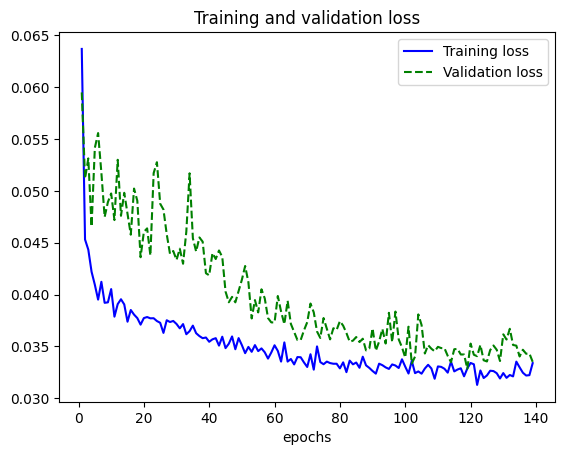

In [16]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_training_loss(training_loss, validation_loss)

Now we can see how the model predicts the power consumption for the next hour. To do this, I plot the actual and predicted power consumption over time

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026D69921A20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


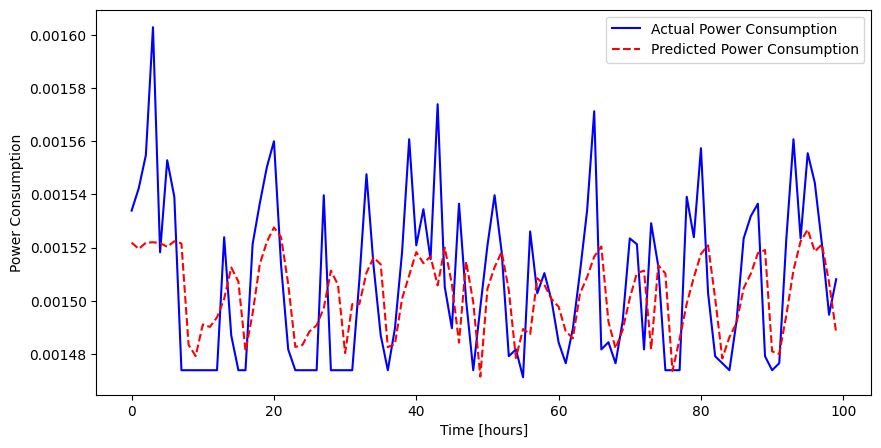

In [17]:
y_pred = model.predict(x_test)

# Reverse the scaling
y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()] * len(features)))[:, 0]

plot_power_time(y_test=y_test_rescaled, y_pred=y_pred_rescaled)

## Establishing a baseline

Since the model's prediction is not as meaningful without a reference, I want to establish a baseline. The simplest baseline for a short term prediction is that the value does not change at all. Therefore, I want a baseline that predicts the current power consumption to be the next hour's power consumption. To be consistent, I also want to use a neural network for the baseline. This has the big advantage that I can evaluate both models with the same functions and a comparison is easy.

The objective is to employ the identical input form as the LSTM network, thereby ensuring the utilization of consistent input data. Given my understanding of the model's intended functionality, I can adjust the weights manually without the need for training. To achieve the previously defined baseline, the model must replicate the current power consumption in the output. Consequently, all weights except for a single one are set to zero.

In [12]:
# Define model as identity function
baseline_model = Sequential([
    Flatten(input_shape = (len(features), sequence_lenght)),
    Dense(1, use_bias=True) 
])

# Set all weights to 0
W = np.zeros((len(features) * sequence_lenght, 1))

# Set current power input weight to 1
W[(sequence_lenght-1)*len(features), 0] = 1

# Set bias to 0
b = np.zeros(1)
baseline_model.layers[1].set_weights([W, b])

c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now I want to verify that the model has the desired behavior by plotting the power prediction again.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


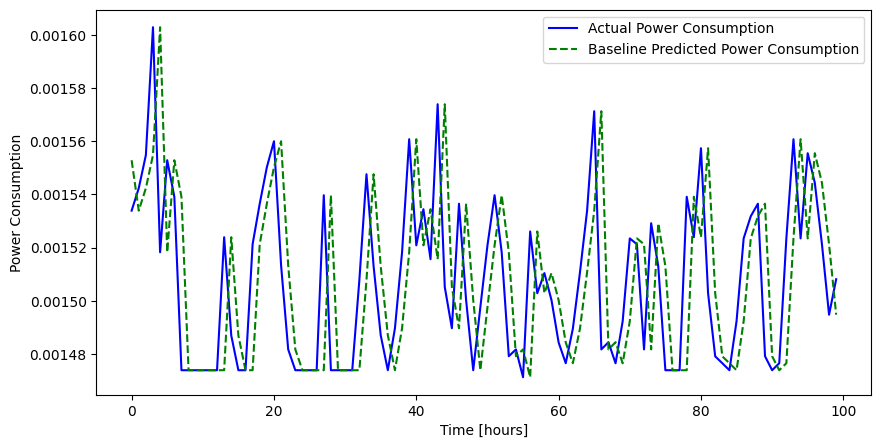

In [13]:
y_baseline_pred = baseline_model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]

plot_power_time(y_test=y_test_rescaled,y_baseline_pred=y_baseline_pred_rescaled)

I want to finish Challenge 1 with a small evaluation. This evaluation calculates the Mean Absolute Error and the Root Mean Squared Error, so that the improvement of the LSTM model over the baseline can be determined in percent.

In [18]:
# Performance comparision

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)) # RMSE is in same unit, intuitive interpretation

mae_baseline = mean_absolute_error(y_test_rescaled, y_baseline_pred_rescaled)
rmse_baseline = np.sqrt(mean_squared_error(y_test_rescaled, y_baseline_pred_rescaled))

print(f"LSTM Model: MAE = {mae_lstm:.4e}, RMSE = {rmse_lstm:.4e}")
print(f"Baseline Model: MAE = {mae_baseline:.4e}, RMSE = {rmse_baseline:.4e}")

mae_improvement = (mae_baseline - mae_lstm) / mae_baseline * 100
rmse_improvement = (rmse_baseline - rmse_lstm) / rmse_baseline * 100

print(f"MAE improvement: {mae_improvement:.2f} %")
print(f"RMSE improvement: {rmse_improvement:.2f} %")

LSTM Model: MAE = 2.0404e-05, RMSE = 2.5791e-05
Baseline Model: MAE = 2.4464e-05, RMSE = 3.2125e-05
MAE improvement: 16.59 %
RMSE improvement: 19.72 %


## Results

The evaluation results indicate that the LSTM model demonstrates superior performance in comparison to the baseline. The LSTM model exhibited a substantial enhancement, achieving approximately 15% improvement across both metrics. While this enhancement is noteworthy, it is not deemed to be significant. It is hypothesized that enhanced outcomes can be attained through the refinement of features, network architecture, and hyperparameters. In the context of extensive research, the utilization of tools such as "Weights and Biases" can facilitate parameter sweeps. Moreover, statistically robust results are best achieved by training and evaluating multiple models. This approach enables the estimation of error metrics with standard error.

Another promising approach involves the application of additional methods, such as gradient boosting, to address this issue. This objective can be achieved by leveraging the capabilities of the XGBoost package.

However, it is important to note that limitations may arise from the small size of the data set and its correlation. The latter is a challenge that is difficult to surmount; however, the former can be addressed by augmenting the dataset with additional data. One potential approach involves generating synthetic data.

# Challenge 2
---
## Desciption
ESA wants to deploy the latest forecast model to the ISS so that ISS astronauts can also run the forecast
by themselves, without waiting for the forecast predictions from Earth. To do that, the forecast model
must be serialized and sent to the ISS. However, the machine on ISS only runs Java, while the forecast
model is in Python. What do you recommend? Please choose the BEST possible answer and justify
your choice.
## Solution
It is evident that options 1 and 2 are not viable solutions. The utilization of Pickle is not recommended due to its lack of language independence, and the employment of CSV is not viable as it is incapable of accommodating the complete set of necessary information. Protocol Buffers, while a promising alternative, would require a significant investment to implement.

For a Tensorflow.Keras model analogous to the one utilized for the task, the "SavedModel" format would be the optimal choice due to its optimization for machine learning models, comprehensive data representation, and the fact that it can be loaded using the Tensorflow Java extension. [Source](https://www.tensorflow.org/jvm/install)

In the event that a different machine learning model is employed, the "Open Neural Network Exchange" library can be utilized to transform the model into a universal format that is cross-platform compatible. [Source](https://onnx.ai/)

**It is imperative to acknowledge that a proposed approach must undergo rigorous testing and validation prior to its implementation in a real-world setting. This principle holds generally, but it is especially crucial in the context of sending data to the ISS.**


# Challenge 3
---
## Desciption
This graph shows the electric consumption over time of the Space mission. If we compute the
correlation between this year and the previous year, what do you think its value would be and why?

![electric consumption over time graph](graph.png "electric consumption over time graph")

## Solution

It is reasonable to hypothesize a value close to 1. The graph demonstrates a consistent increase in electric consumption over time, indicating a positive correlation between the two variables. The presence of strong seasonal variations, with periodic peaks and valleys, does not disrupt the overall upward trend. 

If the value were closer to 0, it would indicate a less pronounced trend, which is not the case. Conversely, a negative value would imply a decrease in electric consumption over time, which is not observed in the data. A value of 0 would indicate no correlation, suggesting a distribution of the data with no presence of a clear linear pattern.
